In [1]:
import torch
import torch.nn as nn
from transformer_model import Transformer
from config import get_config, get_weights_file_path
from main import get_model, get_ds, greedy_decode
import altair as alt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

c:\Users\pingj\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


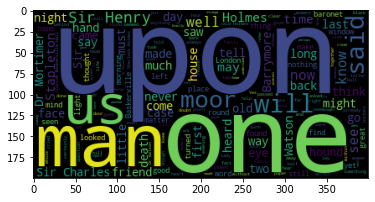

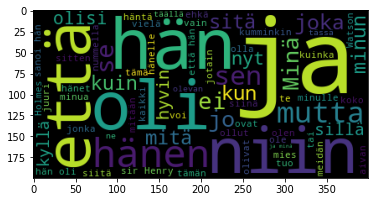

Max length of source sentence: 141
Max length of target sentence: 64
Vocab size of source sentence: 15698
Vocab size of target sentence: 4176


<All keys matched successfully>

In [3]:
config = get_config()
train_dataloader, val_dataloader, vocab_src, vocab_tgt = get_ds(config)
model = get_model(config, vocab_src.get_vocab_size(), vocab_tgt.get_vocab_size()).to(device)

# Load the pretrained weights
model_filename = get_weights_file_path(config, f"200")
state = torch.load(model_filename)
model.load_state_dict(state['model_state_dict'])

In [4]:
def load_next_batch():
    # Load a sample batch from the validation set
    batch = next(iter(val_dataloader))
    encoder_input = batch["encoder_input"].to(device)
    encoder_mask = batch["encoder_mask"].to(device)
    decoder_input = batch["decoder_input"].to(device)
    decoder_mask = batch["decoder_mask"].to(device)

    encoder_input_tokens = [vocab_src.id_to_token(idx) for idx in encoder_input[0].cpu().numpy()]
    decoder_input_tokens = [vocab_tgt.id_to_token(idx) for idx in decoder_input[0].cpu().numpy()]

    # check that the batch size is 1
    assert encoder_input.size(
        0) == 1, "Batch size must be 1 for validation"

    model_out = greedy_decode(
        model, encoder_input, encoder_mask, vocab_src, vocab_tgt, config['seq_len'], device)
    
    return batch, encoder_input_tokens, decoder_input_tokens

In [5]:
def mtx2df(m, max_row, max_col, row_tokens, col_tokens):
    return pd.DataFrame(
        [
            (
                r,
                c,
                float(m[r, c]),
                "%.3d %s" % (r, row_tokens[r] if len(row_tokens) > r else "<blank>"),
                "%.3d %s" % (c, col_tokens[c] if len(col_tokens) > c else "<blank>"),
            )
            for r in range(m.shape[0])
            for c in range(m.shape[1])
            if r < max_row and c < max_col
        ],
        columns=["row", "column", "value", "row_token", "col_token"],
    )

def get_attn_map(attn_type: str, layer: int, head: int):
    if attn_type == "encoder":
        attn = model.encoder.layers[layer].self_attention_block.attention_scores
    elif attn_type == "decoder":
        attn = model.decoder.layers[layer].self_attention_block.attention_scores
    elif attn_type == "encoder-decoder":
        attn = model.decoder.layers[layer].cross_attention_block.attention_scores
    return attn[0, head].data

def attn_map(attn_type, layer, head, row_tokens, col_tokens, max_sentence_len):
    df = mtx2df(
        get_attn_map(attn_type, layer, head),
        max_sentence_len,
        max_sentence_len,
        row_tokens,
        col_tokens,
    )
    return (
        alt.Chart(data=df)
        .mark_rect()
        .encode(
            x=alt.X("col_token", axis=alt.Axis(title="")),
            y=alt.Y("row_token", axis=alt.Axis(title="")),
            color="value",
            tooltip=["row", "column", "value", "row_token", "col_token"],
        )
        #.title(f"Layer {layer} Head {head}")
        .properties(height=400, width=400, title=f"Layer {layer} Head {head}")
        .interactive()
    )

def get_all_attention_maps(attn_type: str, layers: list[int], heads: list[int], row_tokens: list, col_tokens, max_sentence_len: int):
    charts = []
    for layer in layers:
        rowCharts = []
        for head in heads:
            rowCharts.append(attn_map(attn_type, layer, head, row_tokens, col_tokens, max_sentence_len))
        charts.append(alt.hconcat(*rowCharts))
    return alt.vconcat(*charts)

In [6]:
batch, encoder_input_tokens, decoder_input_tokens = load_next_batch()
print(f'Source: {batch["src_text"][0]}')
print(f'Target: {batch["tgt_text"][0]}')
sentence_len = encoder_input_tokens.index("[PAD]")

Source: Beyond, two copses of trees moaned and swung in a rising wind.
Target: Sen toisella puolen näkyi pari puuryhmää valittaen kiemurtelevan yltyvän myrskyn käsissä.


In [7]:
layers = [0, 1, 2]
heads = [0, 1, 2, 3, 4, 5, 6, 7]

# Encoder Self-Attention
get_all_attention_maps("encoder", layers, heads, encoder_input_tokens, encoder_input_tokens, min(20, sentence_len))


alt.VConcatChart(...)

In [8]:
# Encoder Self-Attention
get_all_attention_maps("decoder", layers, heads, decoder_input_tokens, decoder_input_tokens, min(20, sentence_len))

alt.VConcatChart(...)

In [9]:
# Encoder Self-Attention
get_all_attention_maps("encoder-decoder", layers, heads, encoder_input_tokens, decoder_input_tokens, min(20, sentence_len))

alt.VConcatChart(...)